# Analize results

In [131]:
import supportFiles.myFunc as myF
import pandas as pd
import numpy as np
import math
import os
import re
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Load and preprocess data

### Function to change table layout

In [2]:
filepath = "./dissertation/"

def load_errors_per_model(filename: str, filepath: str=filepath) -> pd.DataFrame:
    test = pd.read_csv(filepath+filename, sep=',')
    to_concat = []
    error_types = ["TN", "FP", "FN", "TP"]
    for model in [x.split()[0] for x in test.columns if "TP" in x]:
        cols = [model + " " + x for x in error_types]
        temp = test.loc[:, test.columns.isin(["Data Set"] + cols)].rename(columns=dict(zip(cols, error_types)))
        temp["Model"] = model
        to_concat.append(temp)

    return pd.concat(to_concat, axis=0, ignore_index=True)

### Get data from all targets and source models

In [3]:
temp = []

# Get all result files "fscore_b_SCAN_*.csv"
files = [s for s in os.listdir(filepath) if ("fscore_b_SCAN" in s and s.endswith(".csv"))]
for file in files:
    # add information to be concatenated
    temp.append(load_errors_per_model(file))
    # find us/os or no sampling tag
    temp[-1]["sampling"] = re.search(r"CIC_?([^_]*)\.csv", file).group(1)
    # name source from filename
    temp[-1]["origin"] = file.split("_")[3]

# Join as single dataframe
data = pd.concat(temp, names=["lero"], ignore_index=True)
# Drop unnamed column
if "Unnamed: 0" in data.columns:
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
# Rename Data Set as Target to clarify
data.rename(columns={"Data Set": "Target"}, inplace=True)

data

,Target,TN,FP,FN,TP,Model,sampling,origin
0,SCAN_NB15_CIC,21093.0,15582.0,247.0,154.0,DT,,AB-TRAP
1,SCAN_CIC-IDS_CIC,1544295.0,726827.0,158164.0,640.0,DT,,AB-TRAP
2,SCAN_ToN-IoT_CIC,1707077.0,806982.0,20225.0,15980.0,DT,,AB-TRAP
3,SCAN_BoT-IoT_CIC,81538.0,7696.0,3373746.0,139664.0,DT,,AB-TRAP
4,SCAN_internet_CIC,9129714.0,2639.0,82298.0,3238.0,DT,,AB-TRAP
...,...,...,...,...,...,...,...,...
535,SCAN_AB-TRAP_CIC,8692629.0,439724.0,158921.0,3102.0,XGB,us,ToN-IoT
536,SCAN_NB15_CIC,25709.0,10966.0,308.0,93.0,XGB,us,ToN-IoT
537,SCAN_CIC-IDS_CIC,1072085.0,1199037.0,156186.0,2618.0,XGB,us,ToN-IoT
538,SCAN_BoT-IoT_CIC,82927.0,6307.0,1694249.0,1819161.0,XGB,us,ToN-IoT


### Corrections

- Remove tags from target's name
- Update to current names for AB-TRAP data sets

In [4]:
data["Target"] = data.Target.apply(lambda x: re.search(r"SCAN_?([^_]*)_CIC", x).group(1))
data["Target"] = data.Target.replace({'internet': 'WAB-TRAP', 'AB-TRAP': 'LAB-TRAP'})
data["origin"] = data.origin.replace({'internet': 'WAB-TRAP', 'AB-TRAP': 'LAB-TRAP'})
data.head(10)

,Target,TN,FP,FN,TP,Model,sampling,origin
0,NB15,21093.0,15582.0,247.0,154.0,DT,,LAB-TRAP
1,CIC-IDS,1544295.0,726827.0,158164.0,640.0,DT,,LAB-TRAP
2,ToN-IoT,1707077.0,806982.0,20225.0,15980.0,DT,,LAB-TRAP
3,BoT-IoT,81538.0,7696.0,3373746.0,139664.0,DT,,LAB-TRAP
4,WAB-TRAP,9129714.0,2639.0,82298.0,3238.0,DT,,LAB-TRAP
5,NB15,36675.0,0.0,401.0,0.0,LR,,LAB-TRAP
6,CIC-IDS,953125.0,1317997.0,1363.0,157441.0,LR,,LAB-TRAP
7,ToN-IoT,2514059.0,0.0,36205.0,0.0,LR,,LAB-TRAP
8,BoT-IoT,50941.0,38293.0,2686426.0,826984.0,LR,,LAB-TRAP
9,WAB-TRAP,9126543.0,5810.0,85536.0,0.0,LR,,LAB-TRAP


### Helper class distribution set

In [5]:
#setInfo = pd.DataFrame(index=myF.datasetOptions().values())
data.rename(columns={'Data Set':'target'}, inplace=True)
#data.set_index('target', inplace=True)
setInfo = pd.DataFrame(data={'name':['LAB-TRAP', 'NB15', 'CIC-IDS', 'ToN-IoT', 'BoT-IoT', 'WAB-TRAP'],
                             'scan':[162023,401, 158804, 36205, 3513410, 85536],
                             'benign':[9132353, 36675, 2271122, 2514059, 89234, 9132353],
                             'total':[9294376,  38987, 2827677, 5350583, 13427569, 9217889]})
setInfo.set_index('name',inplace=True)
setInfo['scan_ratio'] = setInfo.apply(lambda x: 100*x['scan']/(x['scan']+x['benign']), axis=1)
setInfo
#data={'AB-TRAP':[162023, 9132353, 9294376], 'NB15':[401, 36675, 38987], 'CIC-IDS':[158804, 2271122, 2827677],'ToN-IoT':[36205, 2514059, 5350583], 'BoT-IoT':[3513410, 89234, 13427569], 'internet':[85536, 9132353, 9217889]},

,scan,benign,total,scan_ratio
name,,,,
LAB-TRAP,162023,9132353,9294376,1.743237
NB15,401,36675,38987,1.081562
CIC-IDS,158804,2271122,2827677,6.535343
ToN-IoT,36205,2514059,5350583,1.419657
BoT-IoT,3513410,89234,13427569,97.523097
WAB-TRAP,85536,9132353,9217889,0.927935


### Helper metric functions

Recall(TPR) function

In [132]:
def recall(x: pd.DataFrame, debug: bool=False) -> pd.array:
   '''
      Calculate Recall (aka TPR) from coefficients of a confusion matrix.
   '''
   f = x['TP']/(x['TP'] + x['FN'])
   # if x is a DataFrame, f will be a Series
   if type(f) == pd.Series: return f.fillna(0.)
   # if x is a Series, f will be a numpy.float
   return f if x['TP'] else 0.

recall(pd.DataFrame([[6,1,2,3], [9,1,1,3]], columns=["TP", "FP", "FN", "TN"]), debug=True)
pd.DataFrame([[6,1,2,3], [0,1,0,3]], columns=["TP", "FP", "FN", "TN"]).apply(recall, axis=1)

0    0.75
1    0.00
dtype: float64

Precision function

In [133]:
def precision(x: pd.DataFrame, debug: bool=False) -> pd.array:
   '''
      Calculate Precision from coefficients of a confusion matrix.
   '''
   f = x['TP']
   # if x is a DataFrame, f will be a Series
   if type(f) == pd.Series: return (f/(x['TP'] + x['FP'])).fillna(0.)
   # if x is a Series, f will be a numpy.float
   return f/(x['TP'] + x['FP']) if x['TP'] else 0.

precision(pd.DataFrame([[6,1,2,3], [9,1,1,3]], columns=["TP", "FP", "FN", "TN"]), debug=True)
pd.DataFrame([[6,1,2,3], [9,1,1,3]], columns=["TP", "FP", "FN", "TN"]).apply(precision, axis=1)

0    0.857143
1    0.900000
dtype: float64

F1-score function

In [134]:
def f1score(x: pd.DataFrame, debug: bool=False) -> pd.array:
    '''
       Calculate F1-score from coefficients of a confusion matrix.
    '''
    # if x is a DataFrame, f will be a Series
    if type(x) == pd.DataFrame:
        if 'Precision' in x.columns and 'Recall' in x.columns:
            P = x.Precision
            R = x.Recall
        # if x does not have Precision or Recall, recalculate
        else:
            P = precision(x)
            R = recall(x)

        f = 2*P*R/(P + R)
        return f.fillna(0.)
   
    # if x is a Series, f will be a numpy.float
    else:
        if 'Precision' in x.index and 'Recall' in x.index:
            P = x.Precision
            R = x.Recall
        else:
            P = precision(x)
            R = recall(x)

        f = 2*P*R
        return f/(P+R) if f else 0.
    
print(f1score(pd.DataFrame([[6,1,2,3]], columns=["TP", "FP", "FN", "TN"]), debug=True), '\n')
f1score(pd.DataFrame([[6/7,.75],[0.9, 0.9]], columns=["Precision", "Recall"]), debug=True)

0    0.8
dtype: float64 



0    0.8
1    0.9
dtype: float64

TNR function

In [149]:
def tnr(x: pd.DataFrame, debug: bool=False) -> pd.array:
   '''
      Calculate TNR from coefficients of a confusion matrix.
   '''
   f = x['TN']
   # if x is a DataFrame, f will be a Series
   if type(f) == pd.Series: return (f/(x['TN'] + x['FP'])).fillna(0.)
   # if x is a Series, f will be a numpy.float
   return f/(x['TN'] + x['FP']) if f else 0.

print(tnr(pd.DataFrame([[6,1,2,3], [9,1,1,4]], columns=["TP", "FP", "FN", "TN"]), debug=True))
pd.DataFrame([[6,1,2,3], [0,0,0,0]], columns=["TP", "FP", "FN", "TN"]).apply(tnr, axis=1)

0    0.75
1    0.80
dtype: float64


0    0.75
1    0.00
dtype: float64

### Set new column for Precision, Recall and F1-score per model, source, sampling and target

In [150]:
data["Precision"] = pd.Series(data.apply(precision, axis=1))
data["Recall"] = pd.Series(data.apply(recall, axis=1))
data["F1-score"] = pd.Series(data.apply(f1score, axis=1))
data["TNR"] = pd.Series(data.apply(tnr, axis=1))

data.head()

,Target,TN,FP,FN,TP,Model,sampling,origin,Precision,Recall,F1-score,TNR
0,NB15,21093.0,15582.0,247.0,154.0,DT,,LAB-TRAP,0.009786,0.384040,0.019087,0.575133
1,CIC-IDS,1544295.0,726827.0,158164.0,640.0,DT,,LAB-TRAP,0.000880,0.004030,0.001444,0.679970
2,ToN-IoT,1707077.0,806982.0,20225.0,15980.0,DT,,LAB-TRAP,0.019418,0.441376,0.037199,0.679012
3,BoT-IoT,81538.0,7696.0,3373746.0,139664.0,DT,,LAB-TRAP,0.947774,0.039752,0.076303,0.913755
4,WAB-TRAP,9129714.0,2639.0,82298.0,3238.0,DT,,LAB-TRAP,0.550961,0.037855,0.070843,0.999711


## Build graphs

### Select TPR and TNR for 'confusion matrix' graphs

In [182]:
g1 = data[['Target', 'origin', 'Model', 'Recall', 'TNR']].rename(columns={'Recall':'TPR'})
#g1['origin'] += ' ' + g1['sampling']
#g1.drop('sampling', axis=1, inplace=True)
g1

,Target,origin,Model,TPR,TNR
0,NB15,LAB-TRAP,DT,0.384040,0.575133
1,CIC-IDS,LAB-TRAP,DT,0.004030,0.679970
2,ToN-IoT,LAB-TRAP,DT,0.441376,0.679012
3,BoT-IoT,LAB-TRAP,DT,0.039752,0.913755
4,WAB-TRAP,LAB-TRAP,DT,0.037855,0.999711
...,...,...,...,...,...
535,LAB-TRAP,ToN-IoT,XGB,0.019145,0.951850
536,NB15,ToN-IoT,XGB,0.231920,0.700995
537,CIC-IDS,ToN-IoT,XGB,0.016486,0.472051
538,BoT-IoT,ToN-IoT,XGB,0.517776,0.929321


<Figure size 1200x1000 with 0 Axes>

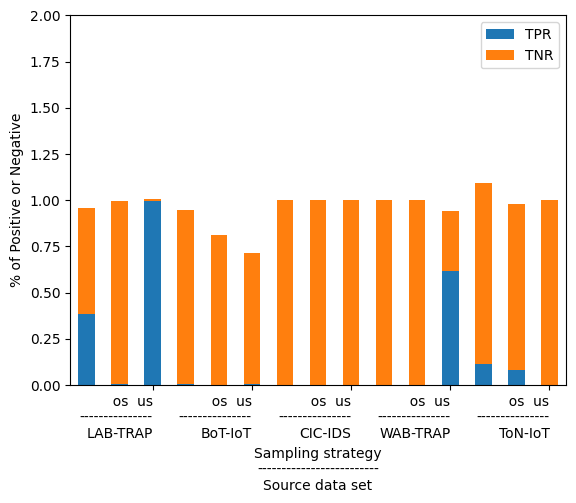

<Figure size 1200x1000 with 0 Axes>

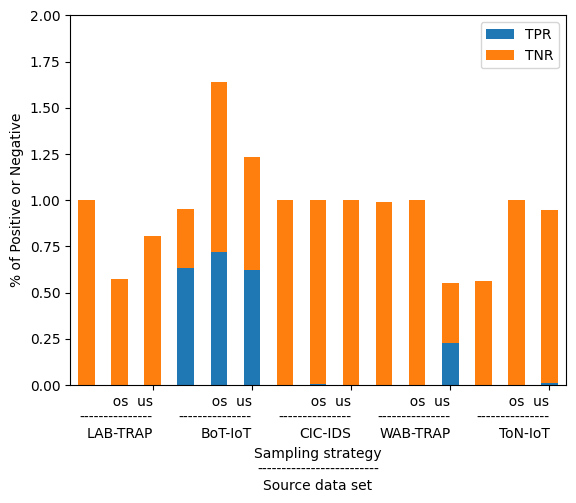

<Figure size 1200x1000 with 0 Axes>

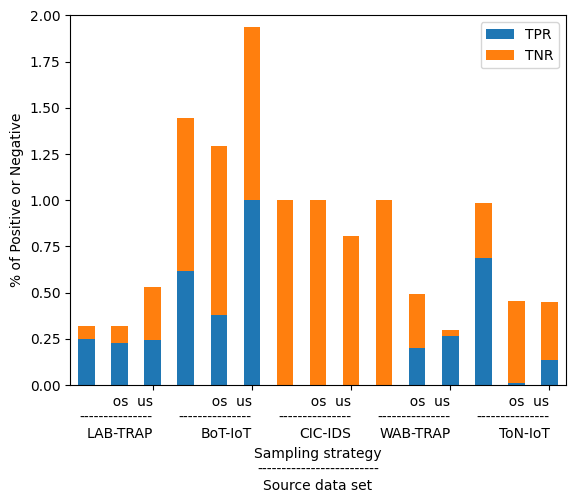

<Figure size 1200x1000 with 0 Axes>

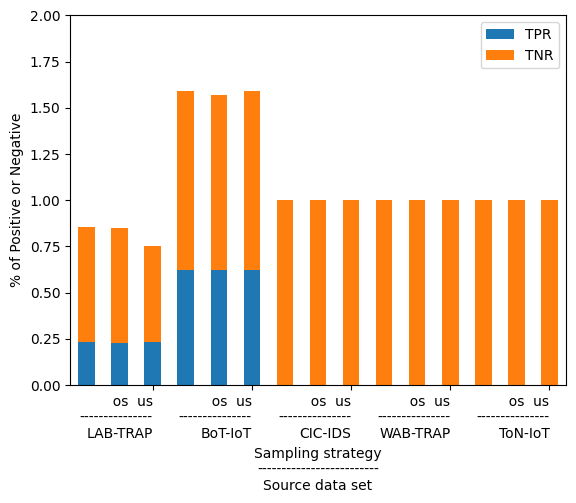

<Figure size 1200x1000 with 0 Axes>

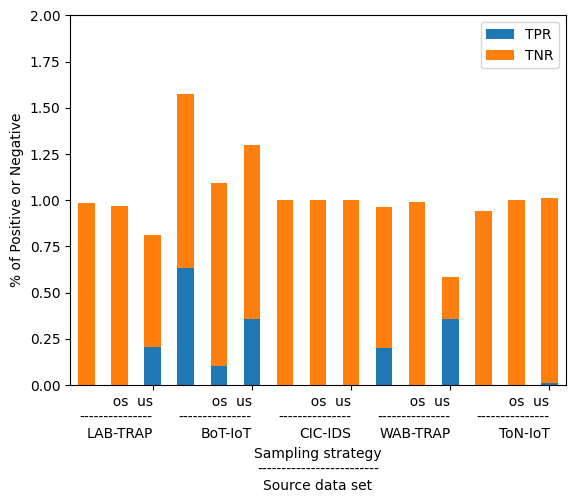

<Figure size 1200x1000 with 0 Axes>

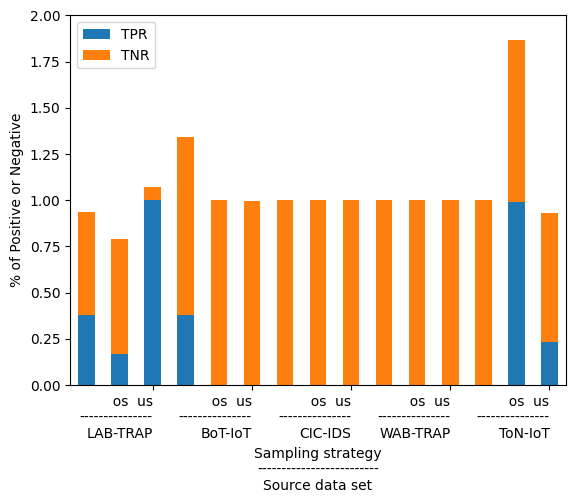

<Figure size 1200x1000 with 0 Axes>

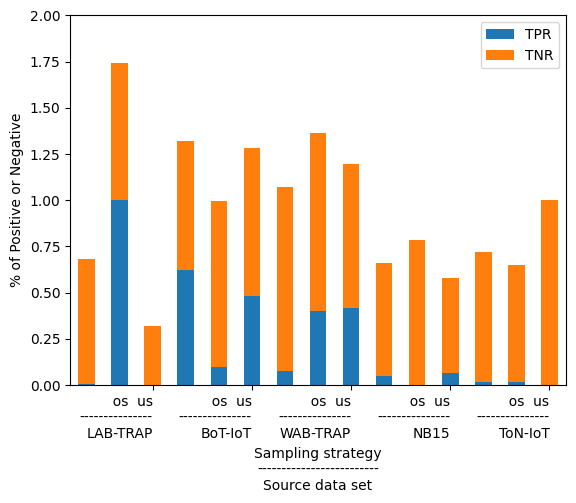

<Figure size 1200x1000 with 0 Axes>

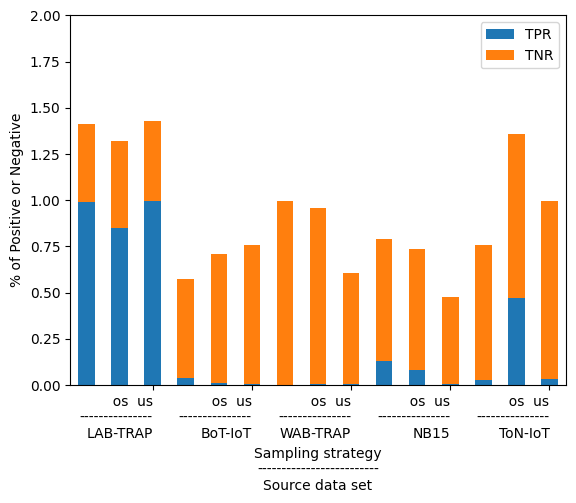

<Figure size 1200x1000 with 0 Axes>

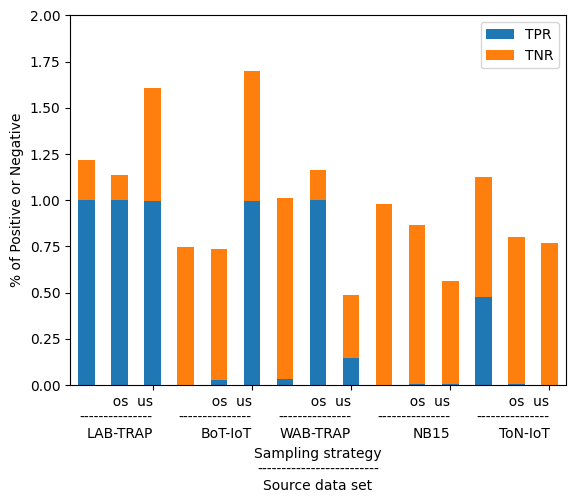

<Figure size 1200x1000 with 0 Axes>

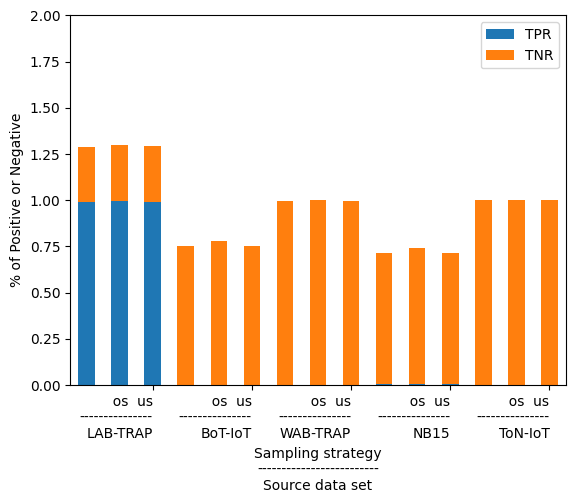

<Figure size 1200x1000 with 0 Axes>

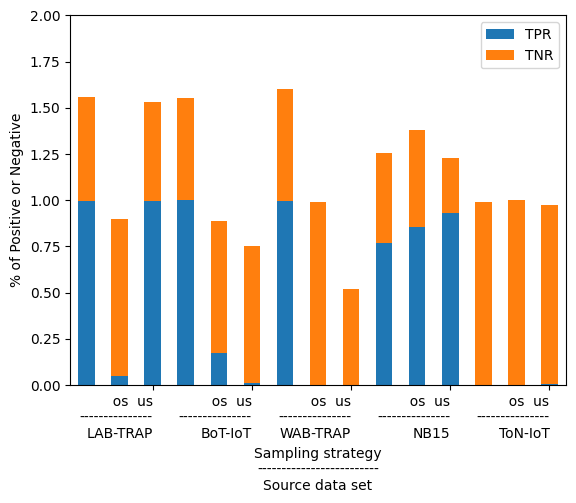

<Figure size 1200x1000 with 0 Axes>

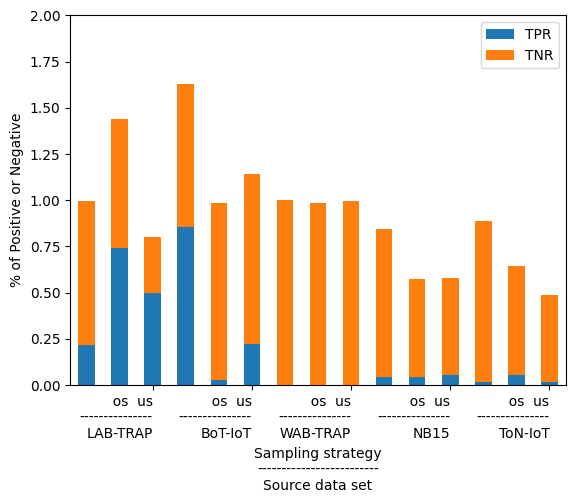

<Figure size 1200x1000 with 0 Axes>

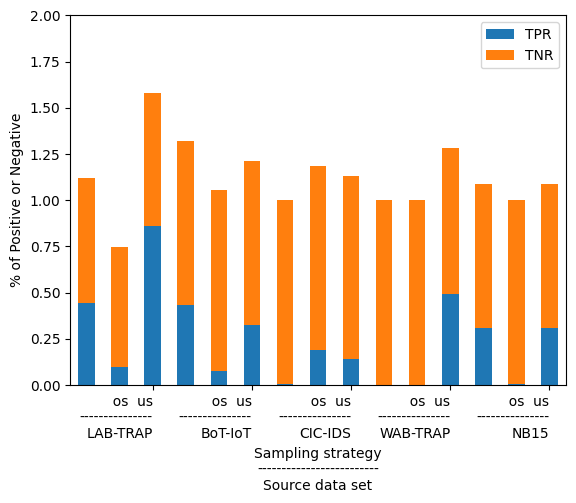

<Figure size 1200x1000 with 0 Axes>

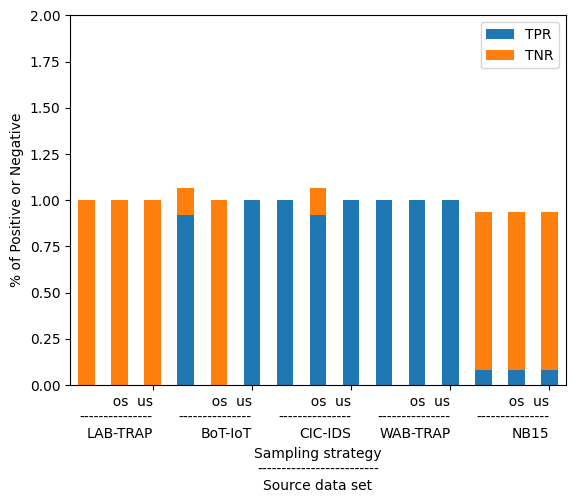

<Figure size 1200x1000 with 0 Axes>

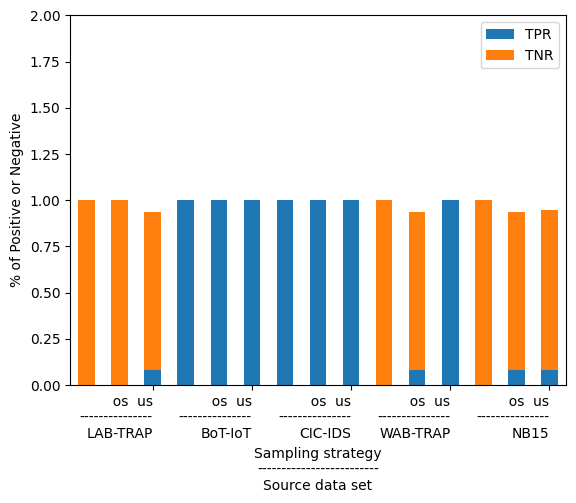

<Figure size 1200x1000 with 0 Axes>

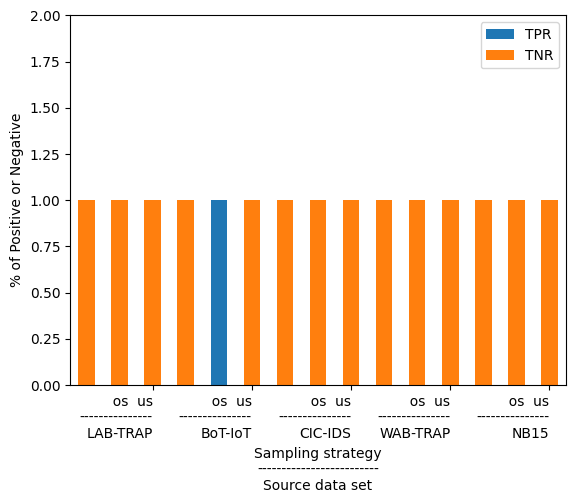

<Figure size 1200x1000 with 0 Axes>

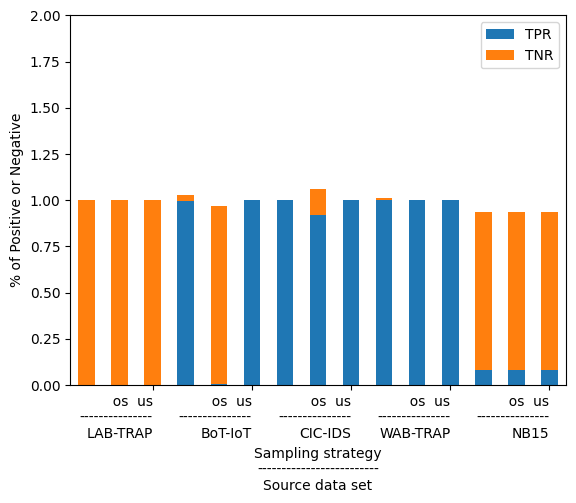

<Figure size 1200x1000 with 0 Axes>

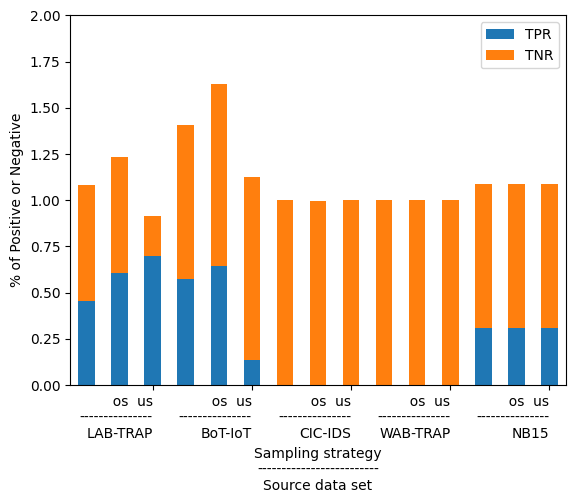

<Figure size 1200x1000 with 0 Axes>

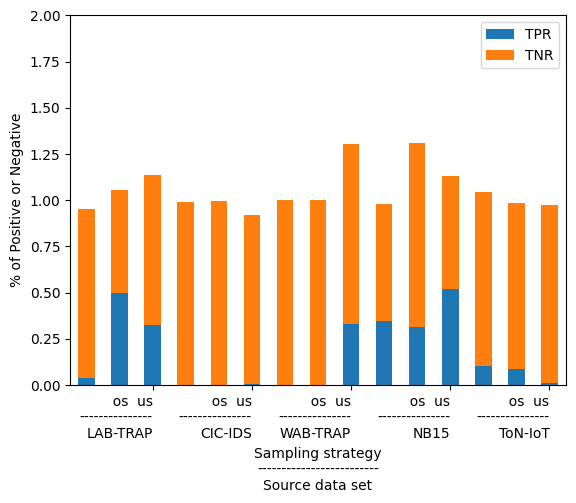

<Figure size 1200x1000 with 0 Axes>

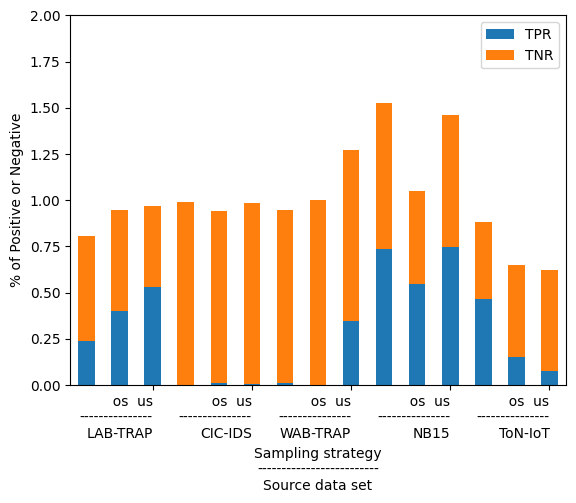

<Figure size 1200x1000 with 0 Axes>

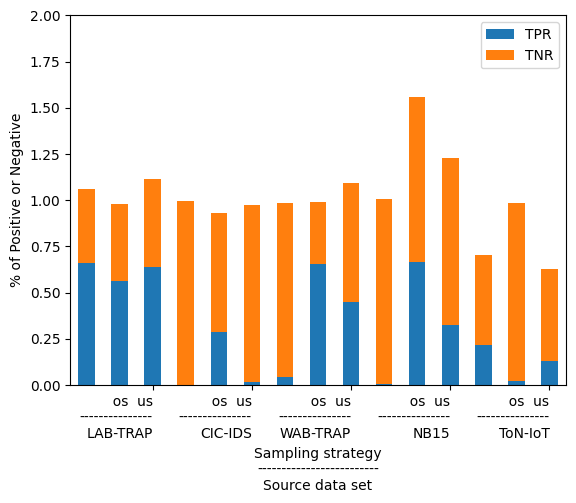

<Figure size 1200x1000 with 0 Axes>

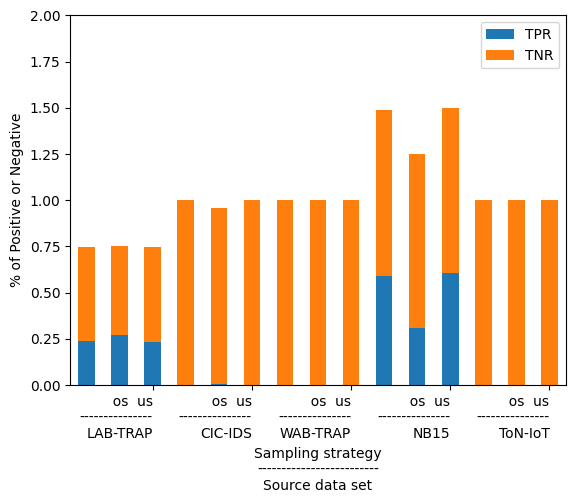

<Figure size 1200x1000 with 0 Axes>

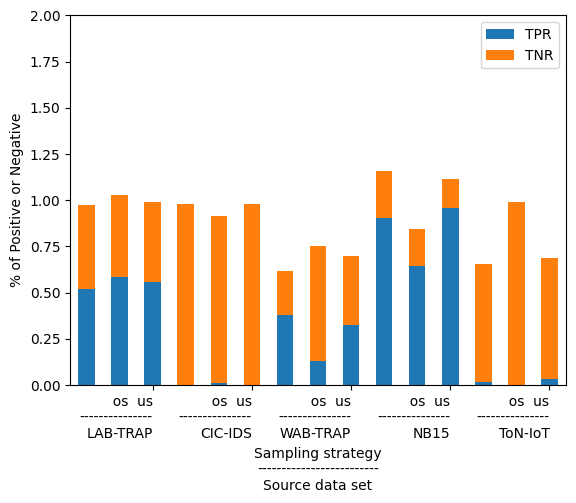

<Figure size 1200x1000 with 0 Axes>

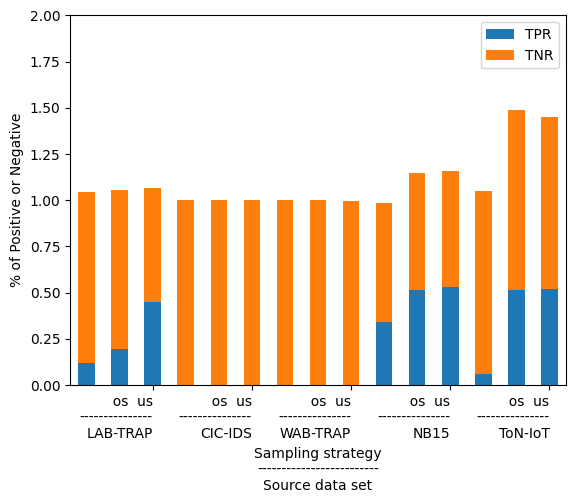

<Figure size 1200x1000 with 0 Axes>

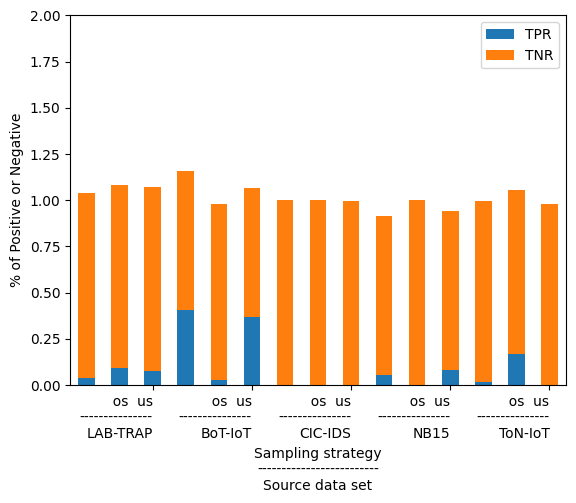

<Figure size 1200x1000 with 0 Axes>

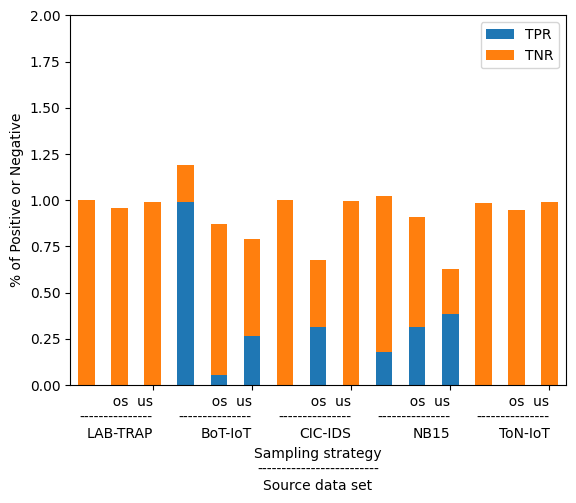

<Figure size 1200x1000 with 0 Axes>

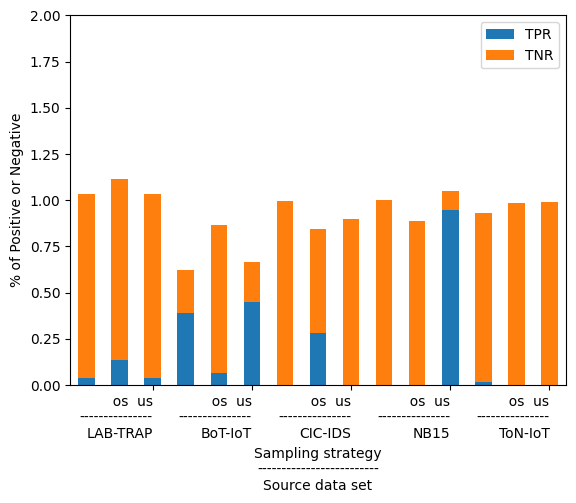

<Figure size 1200x1000 with 0 Axes>

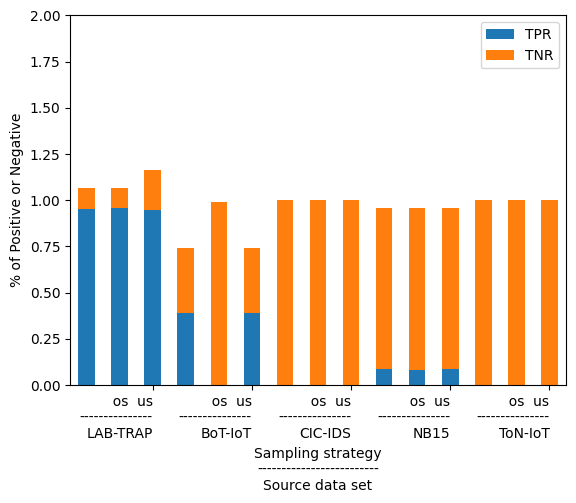

<Figure size 1200x1000 with 0 Axes>

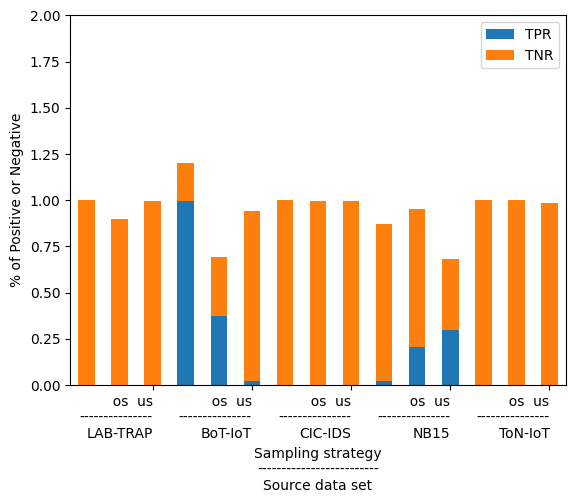

<Figure size 1200x1000 with 0 Axes>

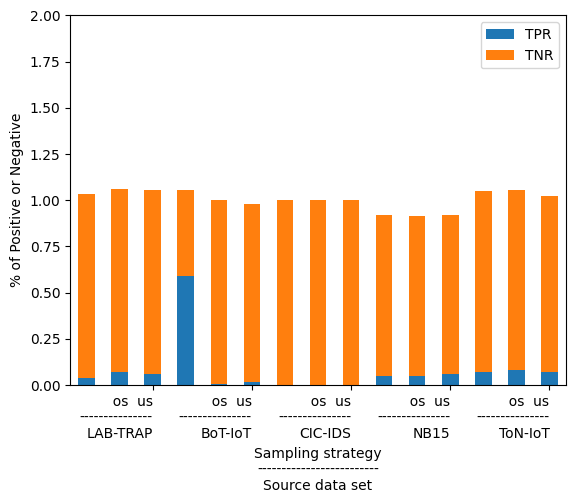

<Figure size 1200x1000 with 0 Axes>

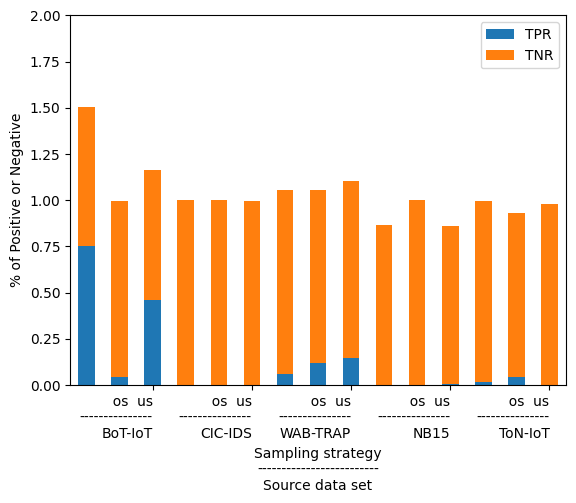

<Figure size 1200x1000 with 0 Axes>

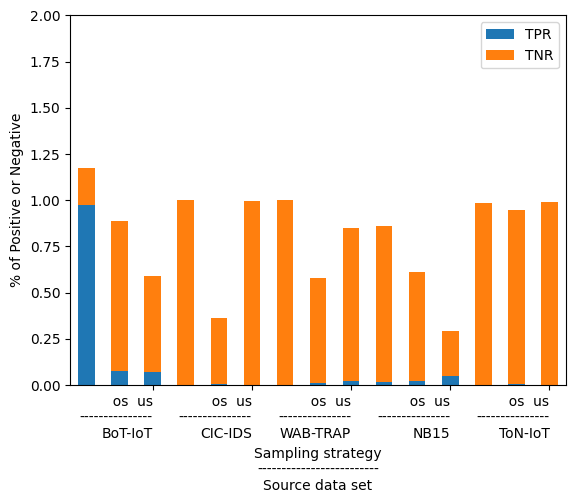

<Figure size 1200x1000 with 0 Axes>

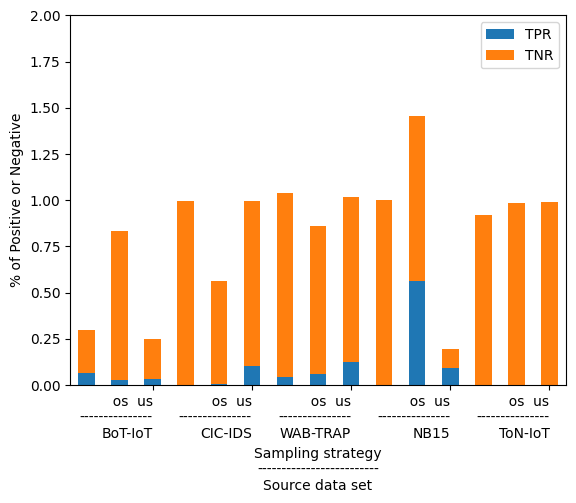

<Figure size 1200x1000 with 0 Axes>

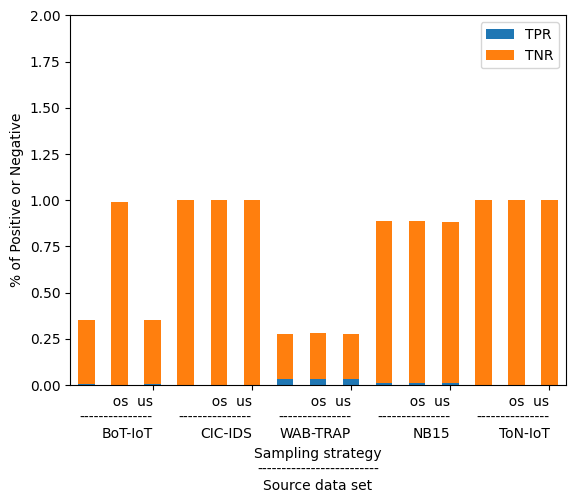

<Figure size 1200x1000 with 0 Axes>

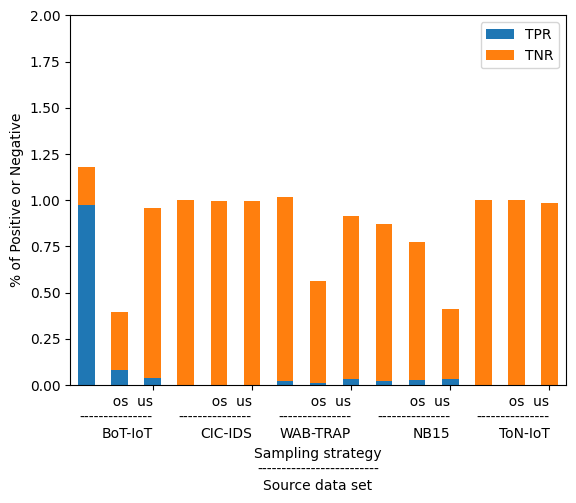

<Figure size 1200x1000 with 0 Axes>

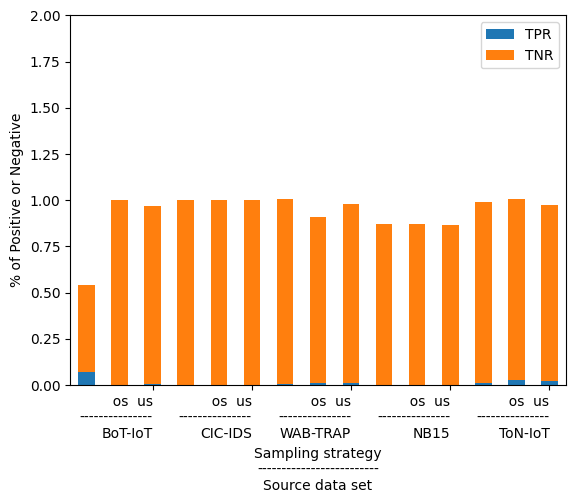

In [196]:

for target in g1['Target'].unique():
    for model in g1['Model'].unique():
        g2 = g1[(g1['Target'] == target)&(g1['Model'] == model)]
        fig = plt.figure(figsize=(12,10))

        ax = g2.plot(x="origin", kind="bar", stacked=True)
        xticks = ('  os  us\n' + '-'*15 + '\n') + g2['origin'].unique()
        ax.set_xticks(np.arange(2, 5*3, 3))
        ax.set_xticklabels( xticks, rotation=0, ha='right')
        ax.set_ylim((0,2.))
        plt.ylabel('% of Positive or Negative')
        plt.xlabel('Sampling strategy\n' + '-'*25 + '\nSource data set')
        plt.savefig("./pdf_images/tpr_tnr_target_{0}_model_{1}.pdf".format(target, model), bbox_inches="tight")

### Select F1-score

In [198]:
g1 = data[['Target', 'origin', 'Model', 'sampling', 'F1-score']]
#g1['origin'] += ' ' + g1['sampling']
#g1.drop('sampling', axis=1, inplace=True)
g1

,Target,origin,Model,sampling,F1-score
0,NB15,LAB-TRAP,DT,,0.019087
1,CIC-IDS,LAB-TRAP,DT,,0.001444
2,ToN-IoT,LAB-TRAP,DT,,0.037199
3,BoT-IoT,LAB-TRAP,DT,,0.076303
4,WAB-TRAP,LAB-TRAP,DT,,0.070843
...,...,...,...,...,...
535,LAB-TRAP,ToN-IoT,XGB,us,0.010257
536,NB15,ToN-IoT,XGB,us,0.016230
537,CIC-IDS,ToN-IoT,XGB,us,0.003849
538,BoT-IoT,ToN-IoT,XGB,us,0.681477


<Figure size 1200x1000 with 0 Axes>

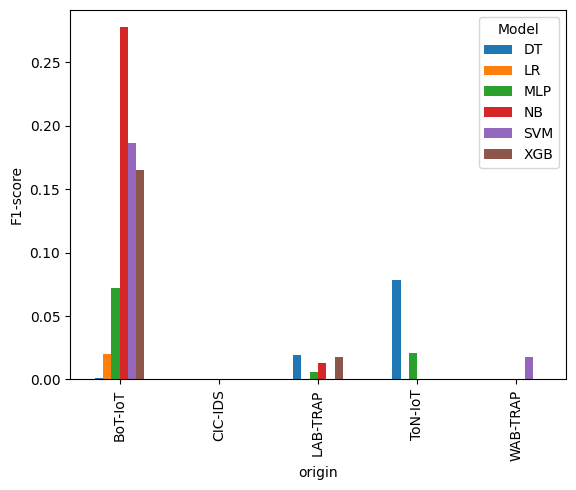

<Figure size 1200x1000 with 0 Axes>

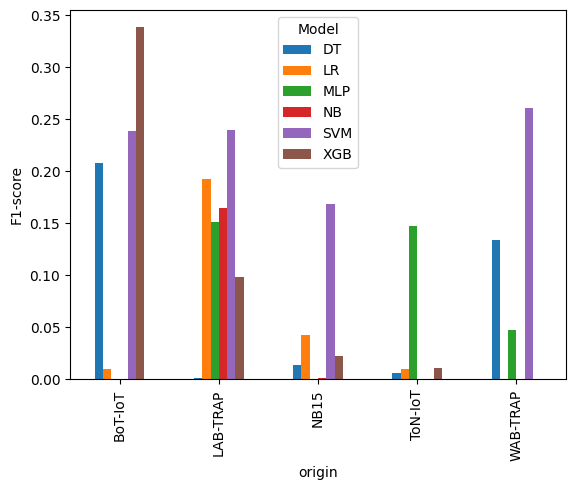

<Figure size 1200x1000 with 0 Axes>

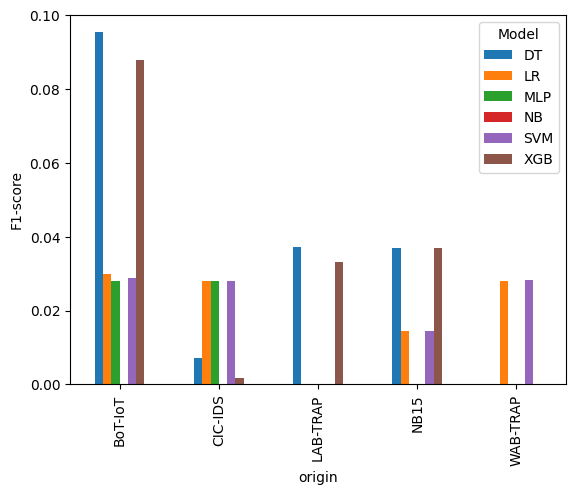

<Figure size 1200x1000 with 0 Axes>

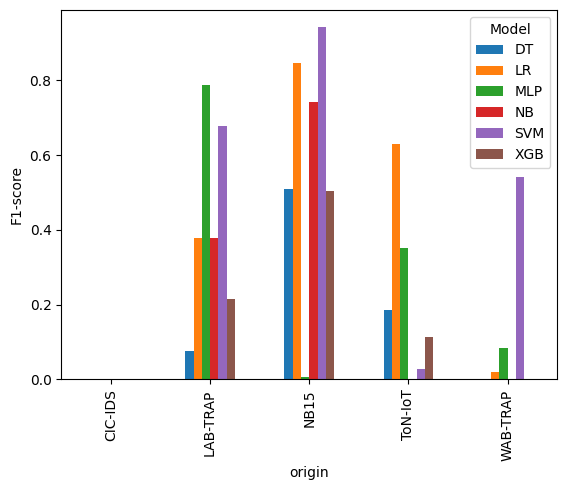

<Figure size 1200x1000 with 0 Axes>

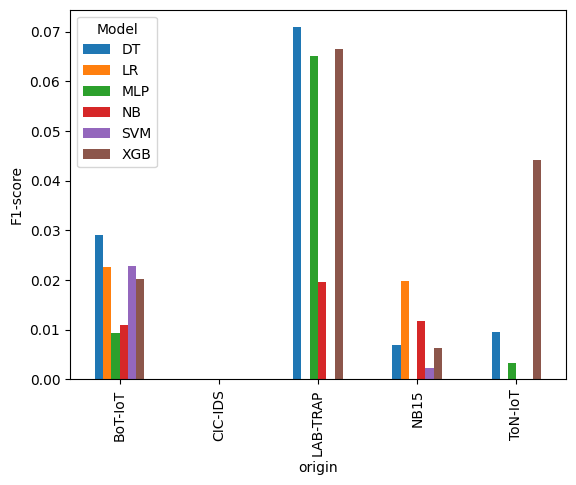

<Figure size 1200x1000 with 0 Axes>

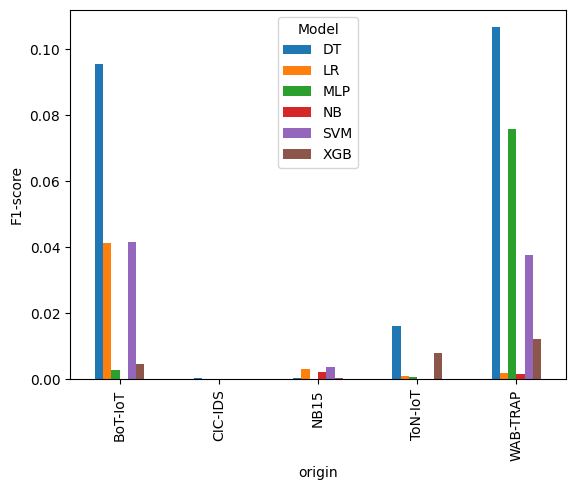

<Figure size 1200x1000 with 0 Axes>

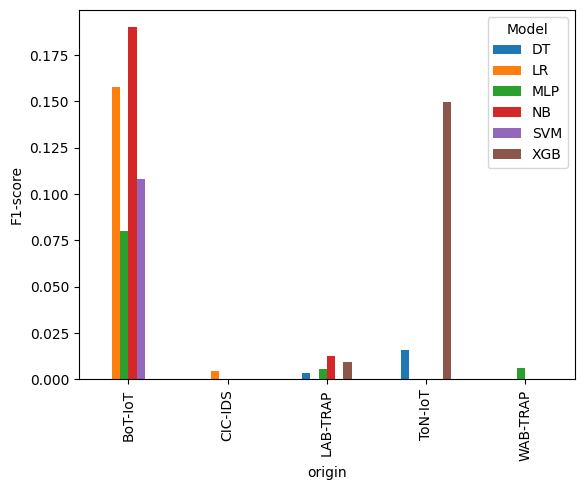

<Figure size 1200x1000 with 0 Axes>

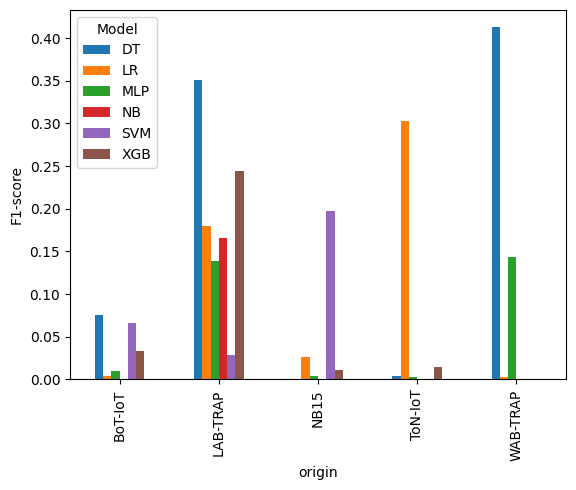

<Figure size 1200x1000 with 0 Axes>

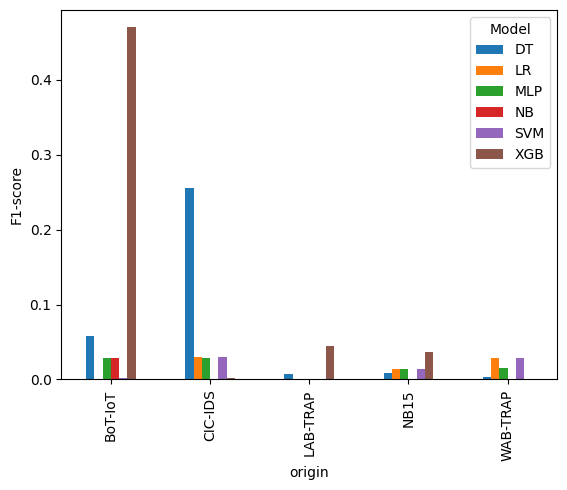

<Figure size 1200x1000 with 0 Axes>

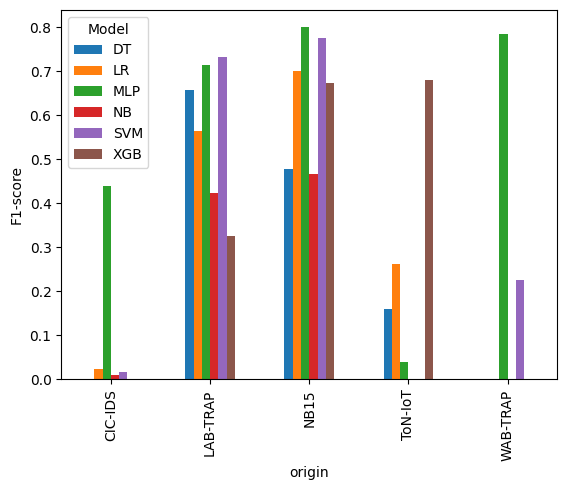

<Figure size 1200x1000 with 0 Axes>

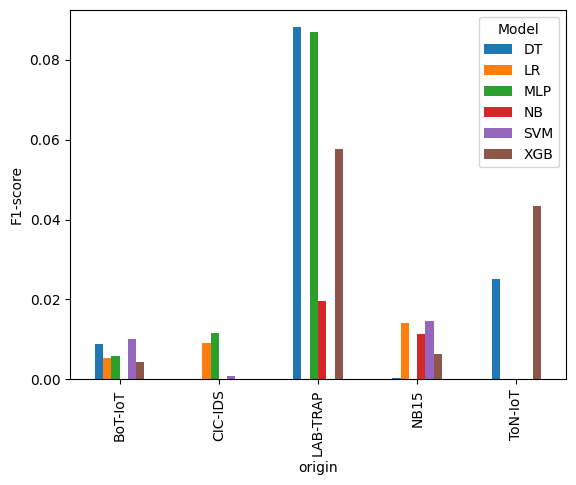

<Figure size 1200x1000 with 0 Axes>

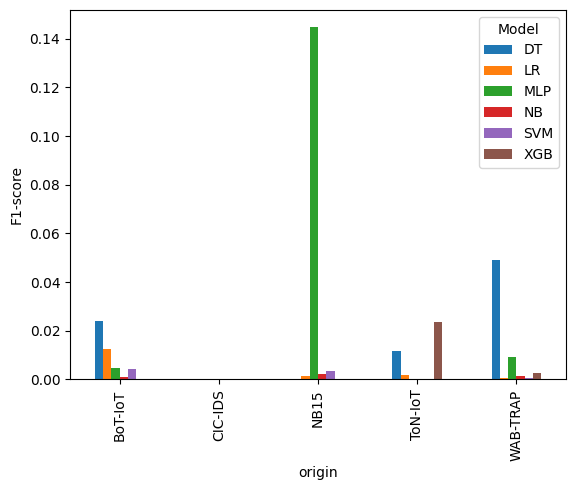

<Figure size 1200x1000 with 0 Axes>

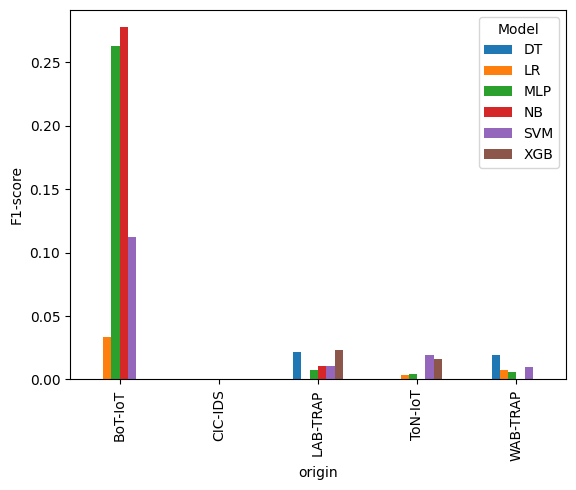

<Figure size 1200x1000 with 0 Axes>

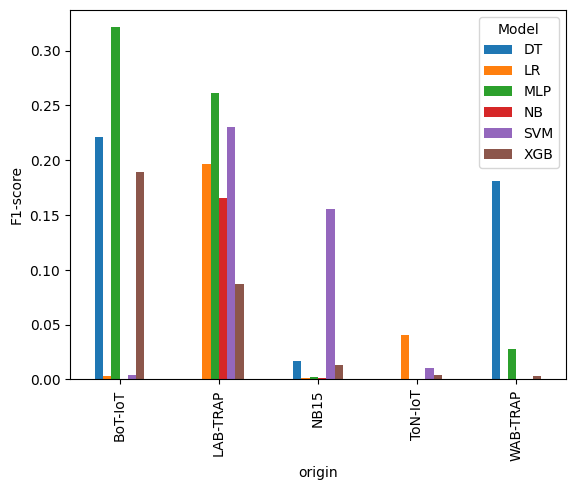

<Figure size 1200x1000 with 0 Axes>

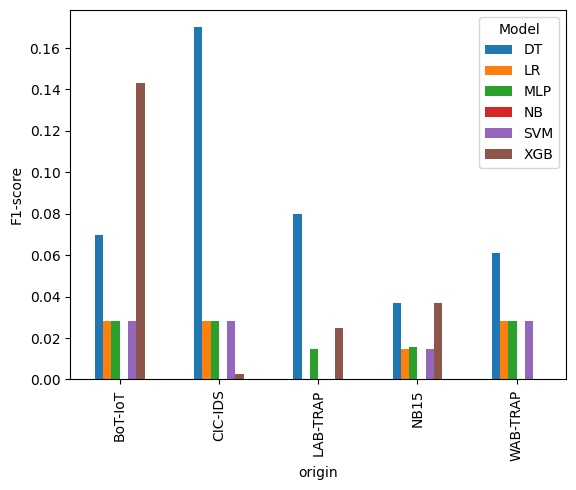

<Figure size 1200x1000 with 0 Axes>

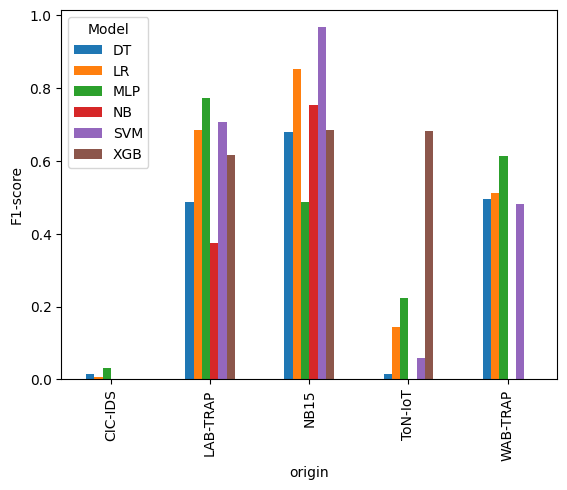

<Figure size 1200x1000 with 0 Axes>

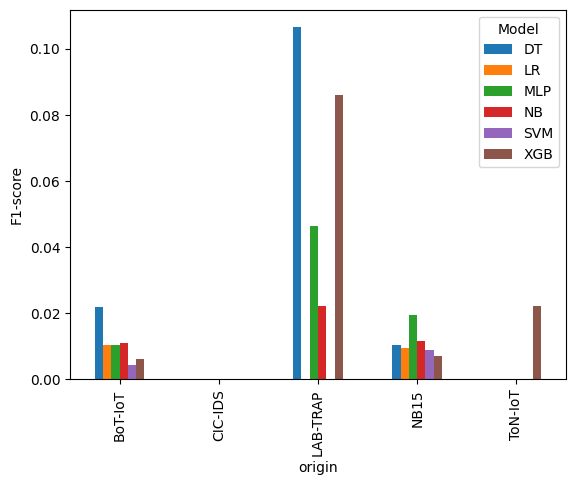

<Figure size 1200x1000 with 0 Axes>

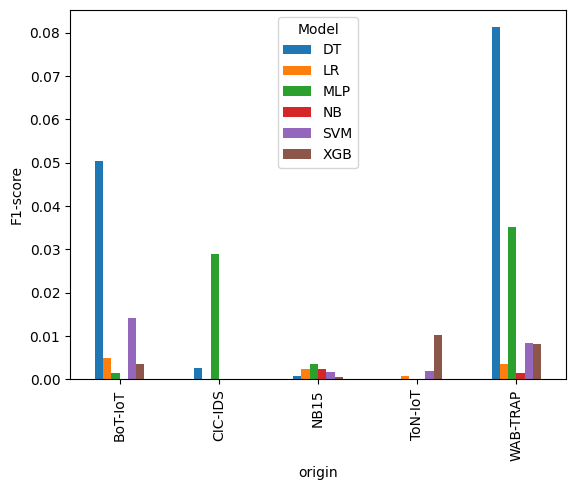

In [207]:
for sampling in ['', 'os', 'us']:
    for target in g1['Target'].unique():
        g2 = g1[(g1['Target'] == target)&(g1['sampling'] == sampling)]
        fig = plt.figure(figsize=(12,10))

        ax = g2.pivot_table(values='F1-score', columns='Model', index='origin').plot(kind="bar", stacked=False)
        #ax.set_ylim((0,1.))
        plt.ylabel('F1-score')
        #plt.xlabel('Sampling strategy\n' + '-'*25 + '\nSource data set')
        plt.savefig("./pdf_images/fscore_{0}_target_{1}.pdf".format(sampling, target), bbox_inches="tight")

### Get MCC function

In [208]:
def mcc(x: pd.DataFrame, debug: bool=False) -> float:
  '''
      Calculate MCC from coefficients of a confusion matrix.
  '''
  Ts = x[["TN","TP"]].to_numpy()
  Fs = x[["FN","FP"]].to_numpy()
  if len(Ts.shape) == 1:
    Ts = Ts.reshape(1,-1)
    Fs = Fs.reshape(1,-1)

  if debug:
    print(Ts)
    print(Ts)
    print(Ts.prod() - Fs.prod())
    print((Ts + Fs.T))
    print((Ts + Fs.T).prod())

  temp = (Ts + Fs.T).prod()
  return (Ts.prod() - Fs.prod())/np.sqrt(temp) if temp else .0

# Test from example in wikipedia
mcc(pd.DataFrame([[6,1,2,3]], columns=["TP", "FP", "FN", "TN"]))

0.47809144373375745

Set new column for MCC per model, source, sampling and target

In [209]:
data["MCC"] = data.apply(mcc, axis=1)
data.head()

,Target,TN,FP,FN,TP,Model,sampling,origin,Precision,Recall,F1-score,TNR,MCC
0,NB15,21093.0,15582.0,247.0,154.0,DT,,LAB-TRAP,0.009786,0.384040,0.019087,0.575133,-0.008544
1,CIC-IDS,1544295.0,726827.0,158164.0,640.0,DT,,LAB-TRAP,0.000880,0.004030,0.001444,0.679970,-0.170527
2,ToN-IoT,1707077.0,806982.0,20225.0,15980.0,DT,,LAB-TRAP,0.019418,0.441376,0.037199,0.679012,0.030464
3,BoT-IoT,81538.0,7696.0,3373746.0,139664.0,DT,,LAB-TRAP,0.947774,0.039752,0.076303,0.913755,-0.036483
4,WAB-TRAP,9129714.0,2639.0,82298.0,3238.0,DT,,LAB-TRAP,0.550961,0.037855,0.070843,0.999711,0.142696


### Select MCC

In [210]:
g1 = data[['Target', 'origin', 'Model', 'sampling', 'MCC']]
#g1['origin'] += ' ' + g1['sampling']
#g1.drop('sampling', axis=1, inplace=True)
g1

,Target,origin,Model,sampling,MCC
0,NB15,LAB-TRAP,DT,,-0.008544
1,CIC-IDS,LAB-TRAP,DT,,-0.170527
2,ToN-IoT,LAB-TRAP,DT,,0.030464
3,BoT-IoT,LAB-TRAP,DT,,-0.036483
4,WAB-TRAP,LAB-TRAP,DT,,0.142696
...,...,...,...,...,...
535,LAB-TRAP,ToN-IoT,XGB,us,-0.017821
536,NB15,ToN-IoT,XGB,us,-0.015167
537,CIC-IDS,ToN-IoT,XGB,us,-0.252830
538,BoT-IoT,ToN-IoT,XGB,us,0.138989


<Figure size 1200x1000 with 0 Axes>

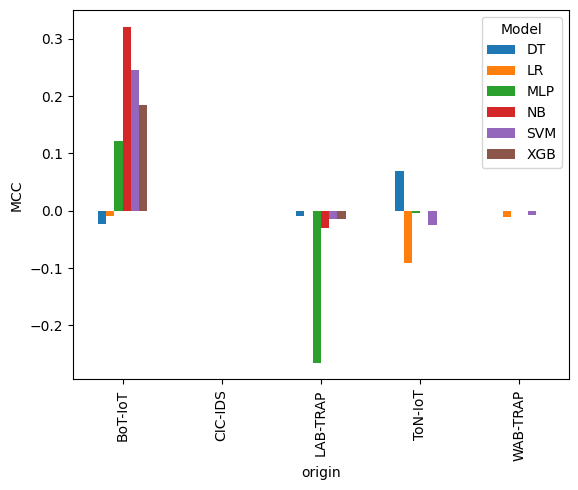

<Figure size 1200x1000 with 0 Axes>

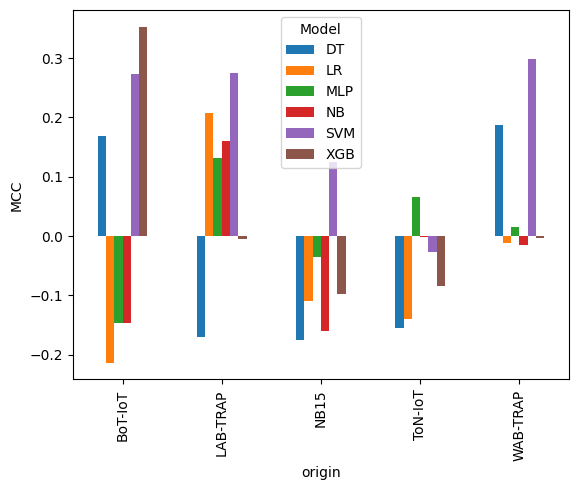

<Figure size 1200x1000 with 0 Axes>

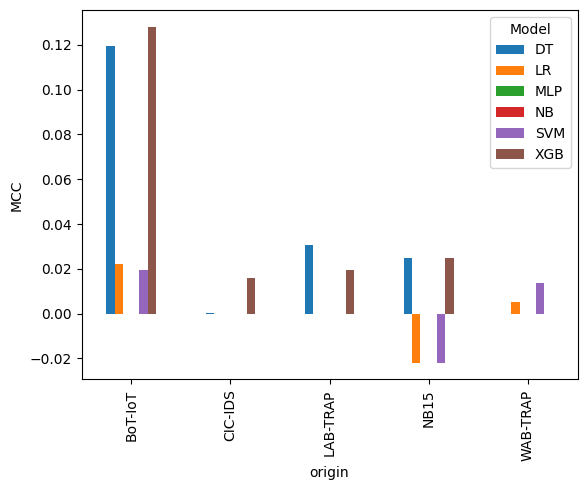

<Figure size 1200x1000 with 0 Axes>

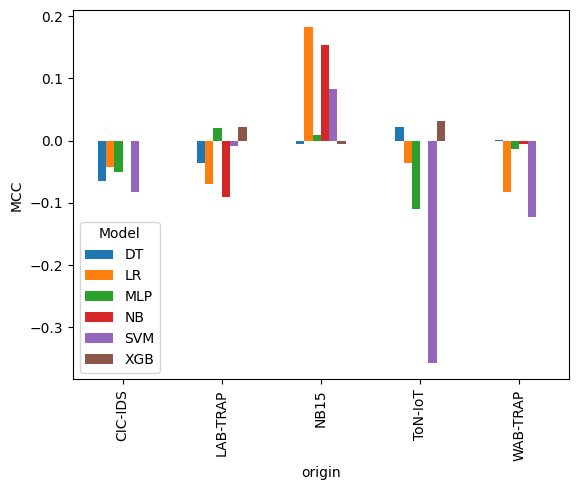

<Figure size 1200x1000 with 0 Axes>

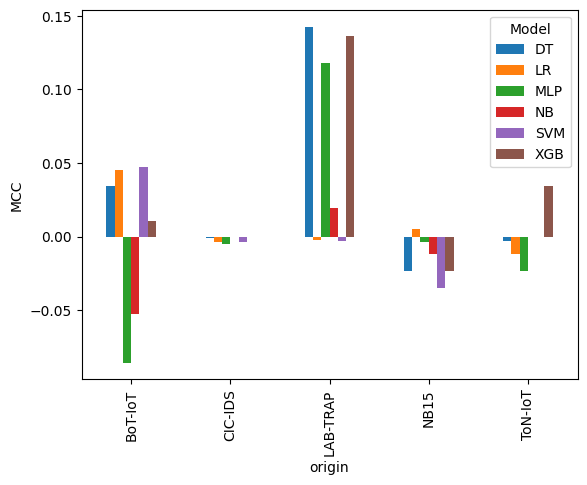

<Figure size 1200x1000 with 0 Axes>

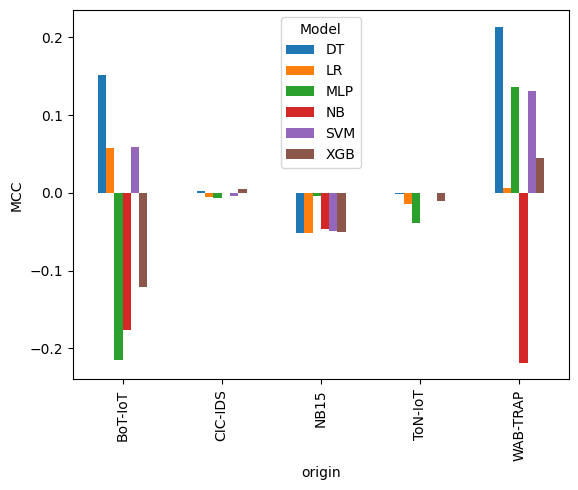

<Figure size 1200x1000 with 0 Axes>

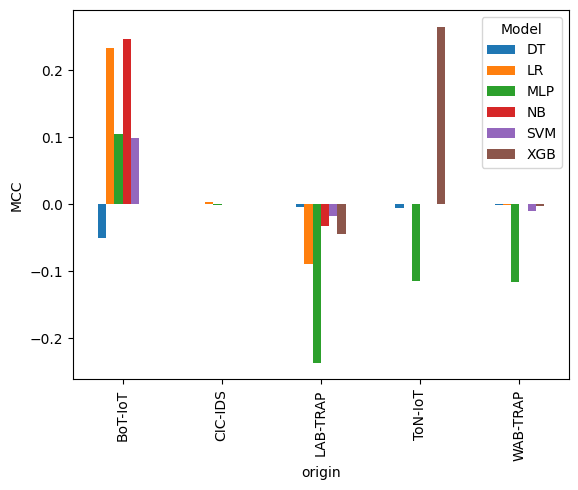

<Figure size 1200x1000 with 0 Axes>

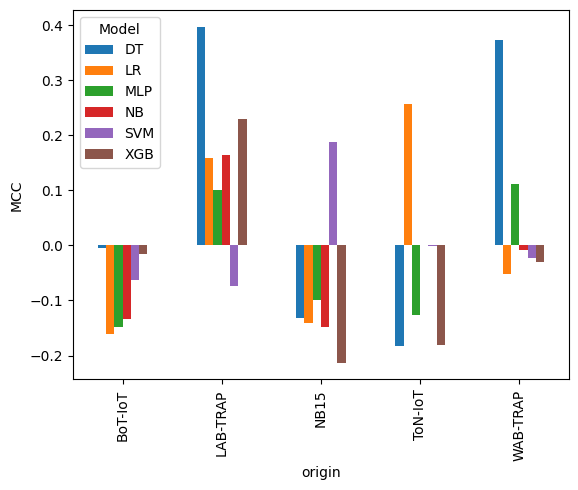

<Figure size 1200x1000 with 0 Axes>

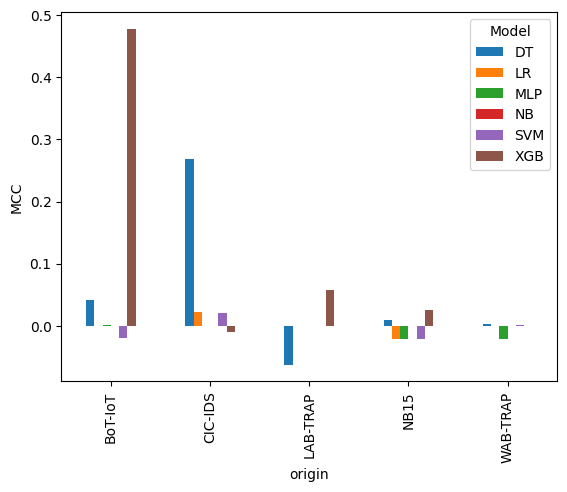

<Figure size 1200x1000 with 0 Axes>

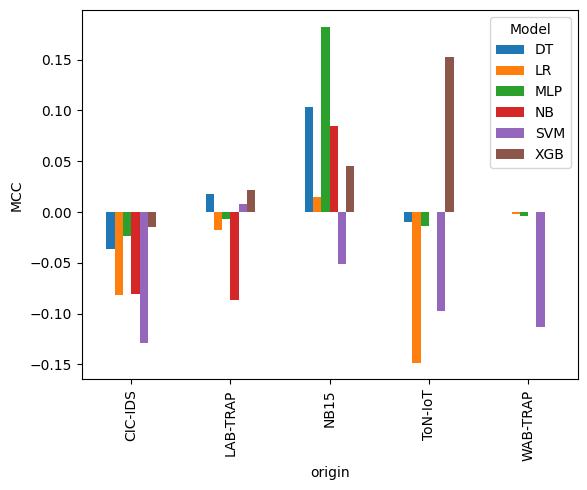

<Figure size 1200x1000 with 0 Axes>

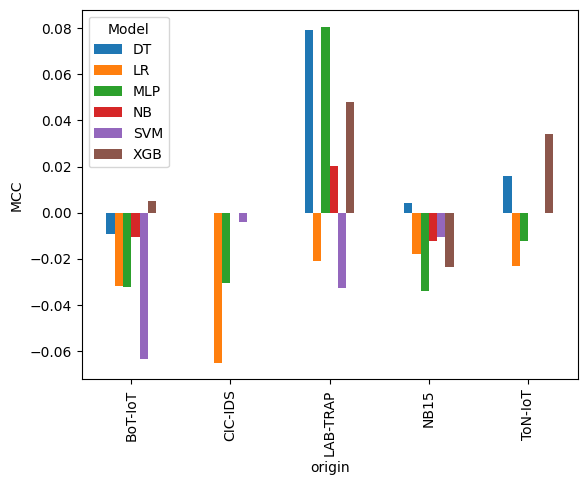

<Figure size 1200x1000 with 0 Axes>

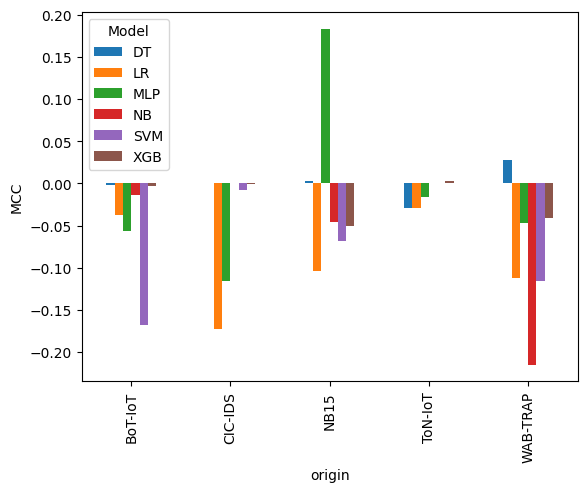

<Figure size 1200x1000 with 0 Axes>

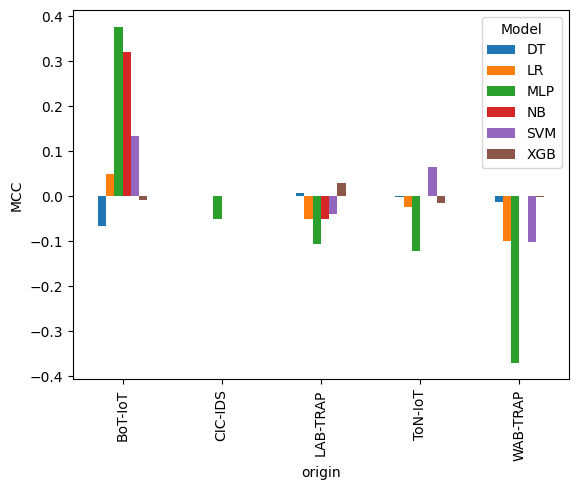

<Figure size 1200x1000 with 0 Axes>

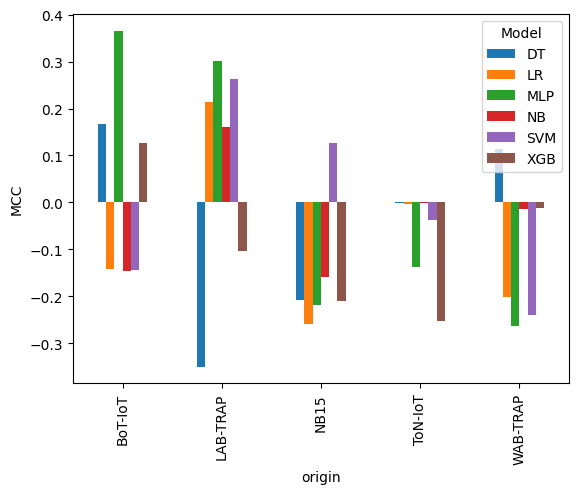

<Figure size 1200x1000 with 0 Axes>

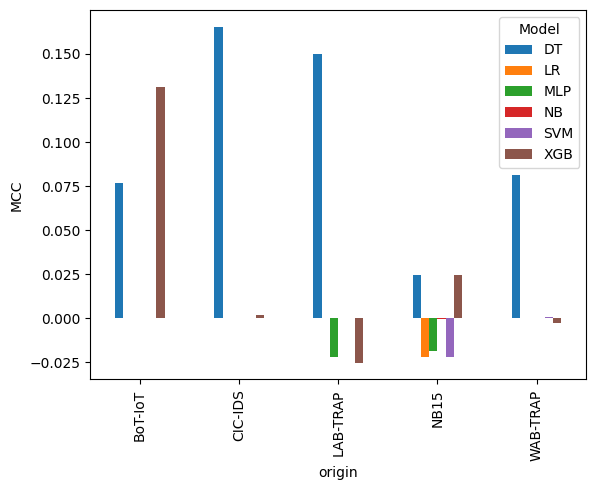

<Figure size 1200x1000 with 0 Axes>

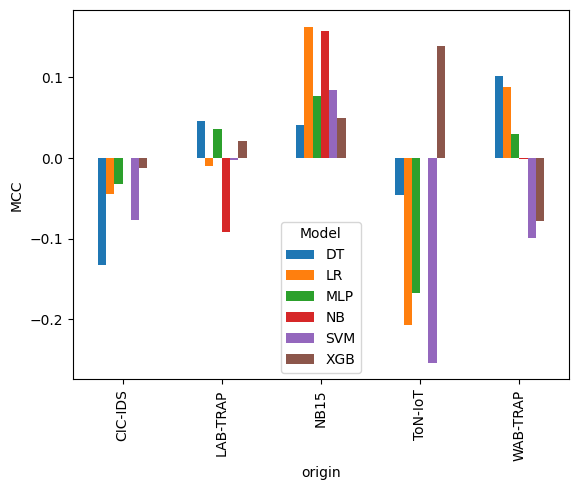

<Figure size 1200x1000 with 0 Axes>

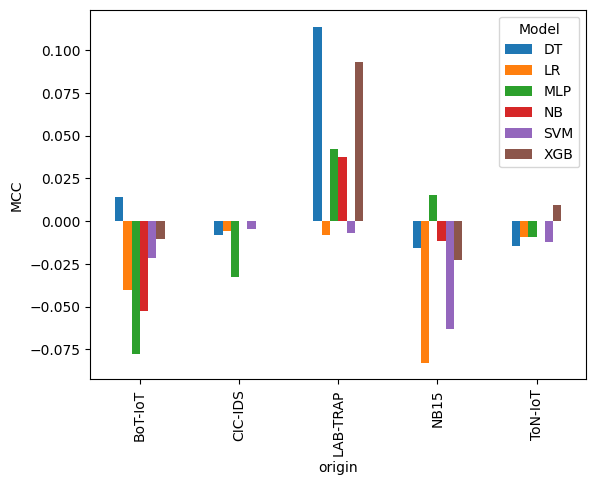

<Figure size 1200x1000 with 0 Axes>

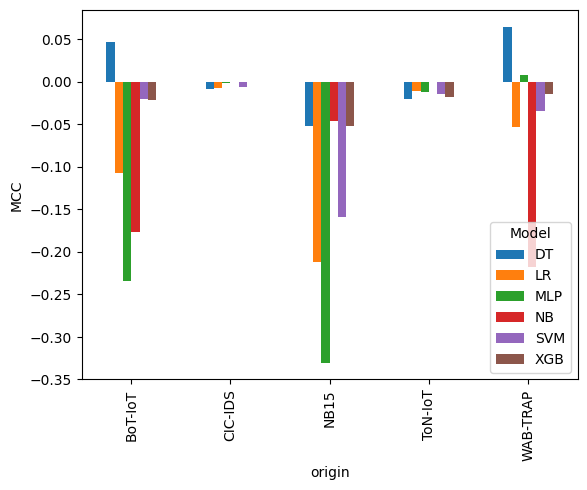

In [211]:
for sampling in ['', 'os', 'us']:
    for target in g1['Target'].unique():
        g2 = g1[(g1['Target'] == target)&(g1['sampling'] == sampling)]
        fig = plt.figure(figsize=(12,10))

        ax = g2.pivot_table(values='MCC', columns='Model', index='origin').plot(kind="bar", stacked=False)
        #ax.set_ylim((0,1.))
        plt.ylabel('MCC')
        #plt.xlabel('Sampling strategy\n' + '-'*25 + '\nSource data set')
        plt.savefig("./pdf_images/MCC_{0}_target_{1}.pdf".format(sampling, target), bbox_inches="tight")

## Make LaTeX for 'confusion matrix' images

In [224]:
for target in ['LAB-TRAP', 'NB15', 'CIC-IDS', 'ToN-IoT', 'BoT-IoT', 'WAB-TRAP']:
    for model in g1.Model.unique():
        print('''\\begin{figure}[H]%[! ht]
        \centering
        \includegraphics[width=0.7\\textwidth]{04ResultsAndDiscussion/new_images/''' + \
        'tpr_tnr_target_{0}_model_{1}.pdf'.format(target, model) + \
        '''}
        \caption{''' + \
        'TPR and TFR for {0} models tested on {1} '.format(model, target) + \
        '''data set per training data sets with different sampling strategies}
        \label{fig:''' + \
        'ConfMatrix_target_{0}_model_{1}'.format(target, model) + \
        '''}
        \end{figure}\n''')

\begin{figure}[H]%[! ht]
        \centering
        \includegraphics[width=0.7\textwidth]{04ResultsAndDiscussion/new_images/tpr_tnr_target_LAB-TRAP_model_DT.pdf}
        \caption{TPR and TFR for DT models tested on LAB-TRAP data set per training data sets with different sampling strategies}
        \label{fig:ConfMatrix_target_LAB-TRAP_model_DT}
        \end{figure}

\begin{figure}[H]%[! ht]
        \centering
        \includegraphics[width=0.7\textwidth]{04ResultsAndDiscussion/new_images/tpr_tnr_target_LAB-TRAP_model_LR.pdf}
        \caption{TPR and TFR for LR models tested on LAB-TRAP data set per training data sets with different sampling strategies}
        \label{fig:ConfMatrix_target_LAB-TRAP_model_LR}
        \end{figure}

\begin{figure}[H]%[! ht]
        \centering
        \includegraphics[width=0.7\textwidth]{04ResultsAndDiscussion/new_images/tpr_tnr_target_LAB-TRAP_model_MLP.pdf}
        \caption{TPR and TFR for MLP models tested on LAB-TRAP data set per training data sets wi

## DT importance

In [225]:
from joblib import load

filename = './models/SCAN_AB-TRAP_CIC_DT.joblib'

In [226]:
model = load(filename)
model

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'class_weight': (None, 'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 10, 15]},
             scoring=make_scorer(f1_score))

In [260]:
features_file = './ML-output/features_AB-TRAP_CIC.txt'
remove_file = './ML-output/zeroVarAB-TRAP_CIC.txt'
with open(features_file) as f1, open(remove_file) as f2:
    v1 = f1.read().split(', ')[:-1]
    v2 = f2.read().split(',')
    features = [x for x in v1 if x not in v2]

len(features)

67

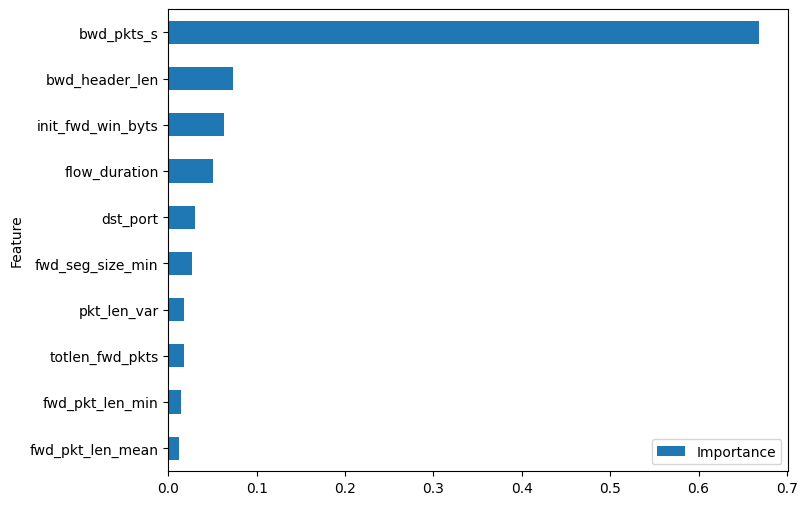

In [270]:
feat_importances = pd.DataFrame(model.best_estimator_.feature_importances_,
                                index=features, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
ax = feat_importances.iloc[-10:].plot(kind='barh', figsize=(8,6) )
ax.set_ylabel("Feature")
plt.show()

In [271]:
import seaborn as sns

In [278]:
next(rel.iterrows())[1]['Importance']

0.01241153345860021

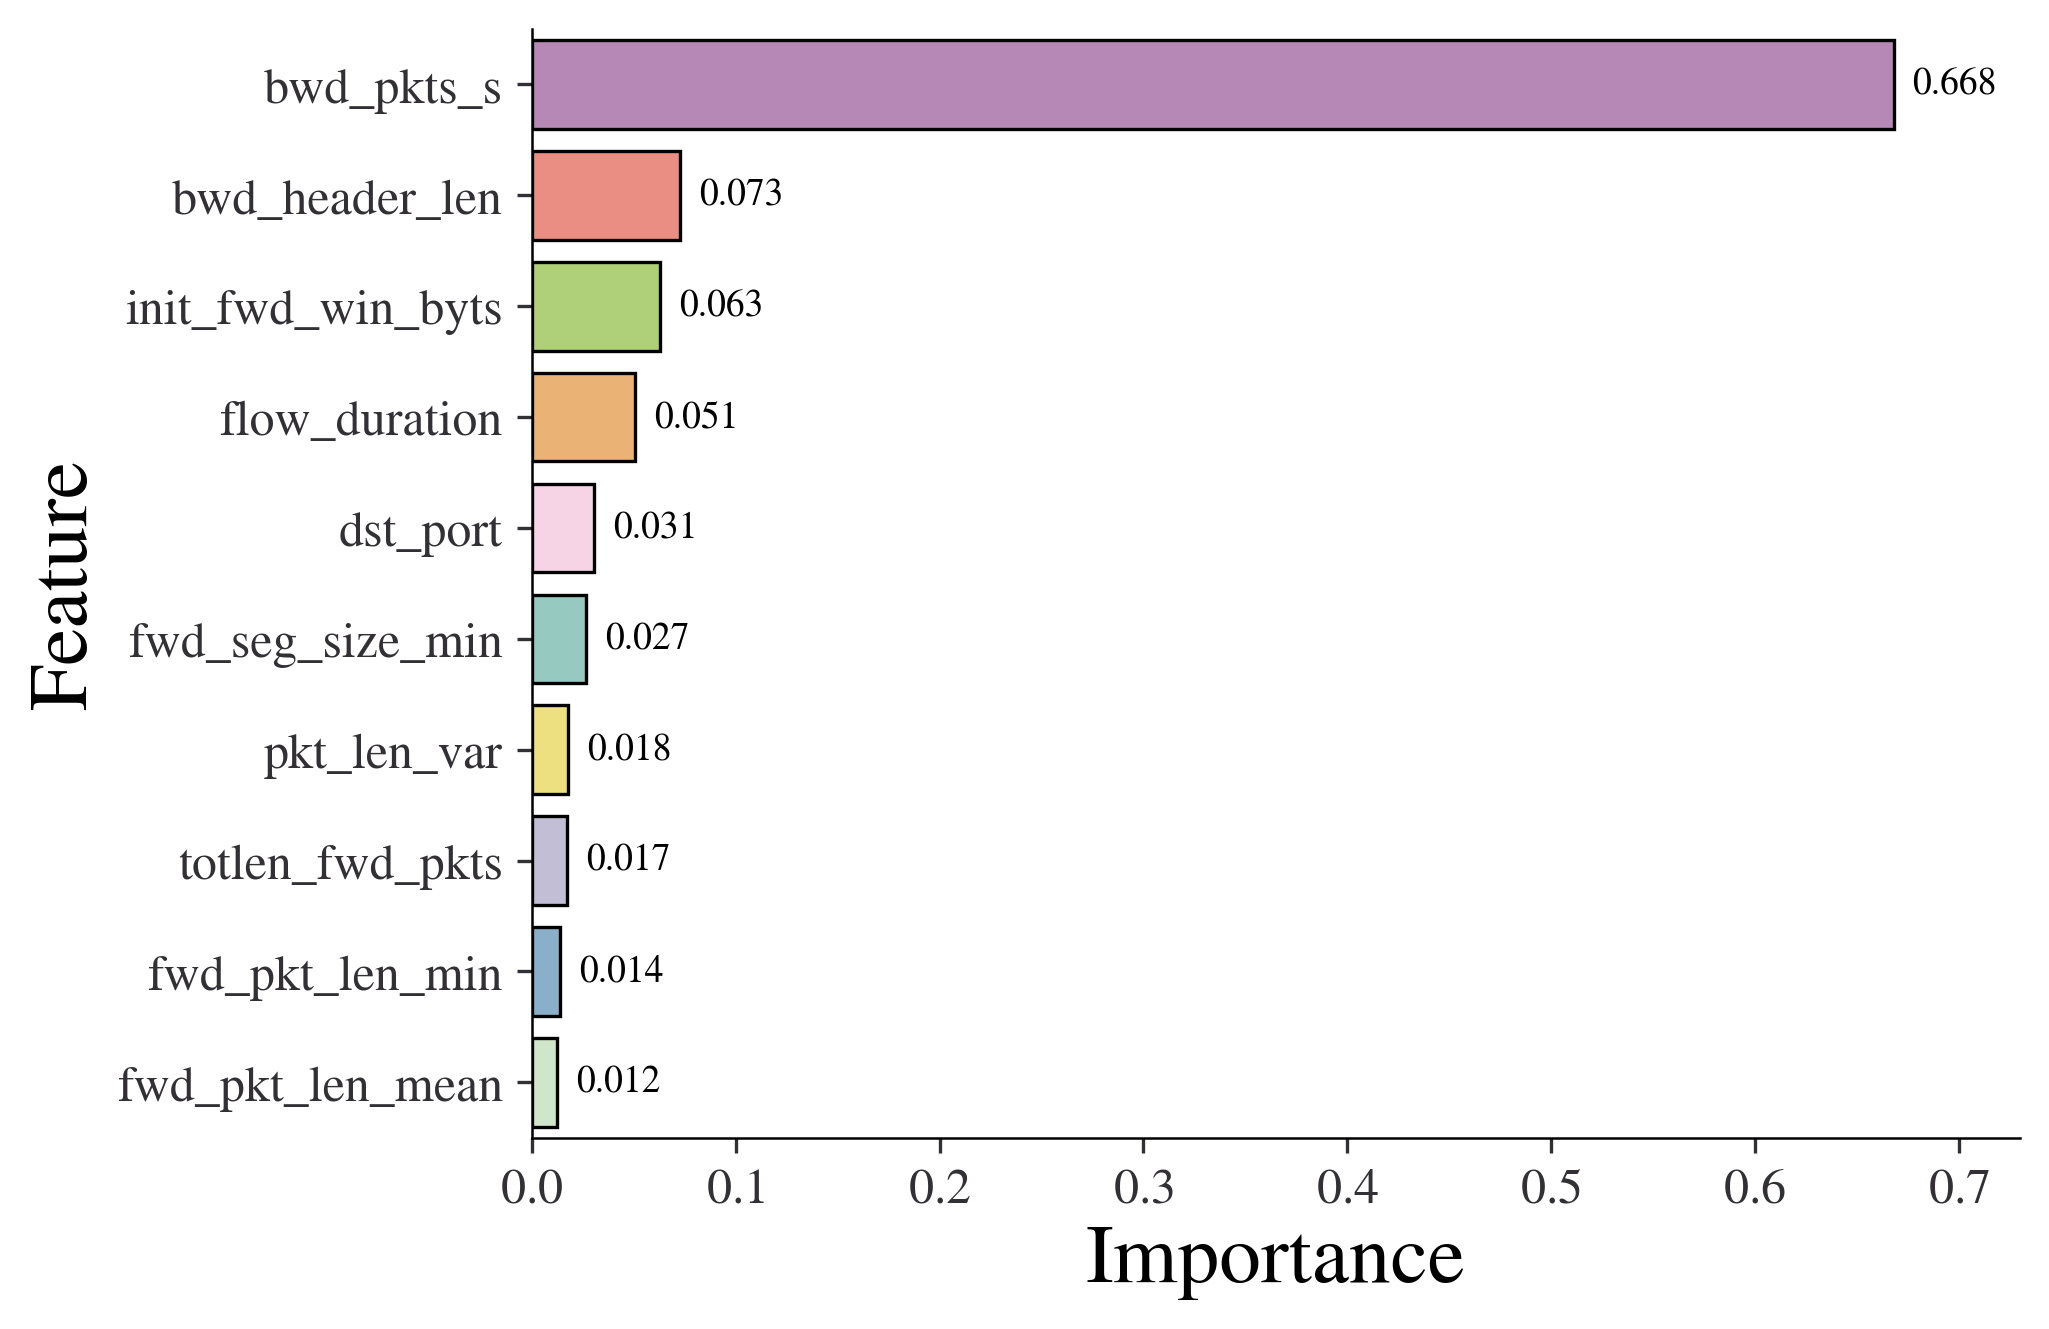

In [288]:
plt.style.use('./supportFiles/plot_style.txt')
rel = feat_importances.sort_values(by='Importance', ascending=False).iloc[:10]
g=sns.barplot(x=rel['Importance'], y=rel.index)

plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20);
plt.xlim(0.,.73)
i=0
for index, row in rel.iterrows():
    g.text(row['Importance']+0.03, i, round(row['Importance'], 3), color='black', ha="center", va="center", fontsize=9)
    i+=1

plt.savefig("./pdf_images/importance_DT_AB-TRAP.pdf", dpi=300, bbox_inches = "tight")